<a href="https://colab.research.google.com/github/OgunSerifOnargan/arkitek_notebooks/blob/main/videoMAE_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NOTEBOOK PREP

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -q pytorchvideo transformers evaluate
!pip install transformers[torch]
!pip install pytorchvideo
!pip install ultralytics

In [ ]:
import pandas as pd
import imageio
import numpy as np
from IPython.display import Image
import torch
import shutil
import os
from tqdm import tqdm
import cv2
from transformers import VideoMAEImageProcessor, VideoMAEForVideoClassification
import pytorchvideo.data

In [ ]:
def unnormalize_img(img):
    """Un-normalizes the image pixels."""
    img = (img * std) + mean
    img = (img * 255).astype("uint8")
    return img.clip(0, 255)

def create_gif(video_tensor, filename="sample.gif"):
    """Prepares a GIF from a video tensor.

    The video tensor is expected to have the following shape:
    (num_frames, num_channels, height, width).
    """
    frames = []
    for video_frame in video_tensor:
        frame_unnormalized = unnormalize_img(video_frame.permute(1, 2, 0).numpy())
        frames.append(frame_unnormalized)
    kargs = {"duration": 1}
    imageio.mimsave(filename, frames, "GIF", **kargs)
    return filename

def display_gif(video_tensor, gif_name="sample.gif"):
    """Prepares and displays a GIF from a video tensor."""
    video_tensor = video_tensor.permute(1, 0, 2, 3)
    gif_filename = create_gif(video_tensor, gif_name)
    return Image(filename=gif_filename)


def run_inference(model, avideo):
    # (num_frames, num_channels, height, width)
    perumuted_sample_test_video = avideo["video"].permute(1, 0, 2, 3)
    inputs = {
        "pixel_values": perumuted_sample_test_video.unsqueeze(0),
        "labels": torch.tensor(
            [avideo["label"]]
        ),  # this can be skipped if you don't have labels available.
    }

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    model = model.to(device)

    # forward pass
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    return logits

# DATA PREP

In [ ]:
# @title
#output folder creation
def videomae_folder_order_creator(output_folder_path, class_names):
  shutil.rmtree(output_folder_path, ignore_errors=True)
  for folder in ["train","val","test"]:
    for class_name in class_names:
      class_folder_path = output_folder_path + "/" + folder + "/" + class_name
      os.makedirs(class_folder_path, exist_ok=True)

def excel_train_val_test_splitter(df_excel, division_ratios):
  len_train = int(len(df_excel)*division_ratios[0])
  len_val = int(len(df_excel)*division_ratios[1])
  len_test = int(len(df_excel)*division_ratios[2])

  train_df = df_excel[:len_train]
  val_df = df_excel[len_train : (len_train+len_val)]
  test_df = df_excel[(len_train+len_val):]

  return train_df, val_df, test_df


def process_avideo(video_path, label, frame_interval, output_folder_path, folder):

  max_frame, min_frame = frame_interval

  cap = cv2.VideoCapture(video_path)

  new_videos_df = pd.DataFrame(columns=["video_name", "num_frames", "label"])
  frames = []
  try:
      frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
      fps = cap.get(cv2.CAP_PROP_FPS)
      while True:
          ret, frame = cap.read()
          if not ret:
              break
          frames.append(frame)
  finally:
      cap.release()

  video_index = 0
  while frames:
      video_name = video_path.split("/")[-1].split(".")[-2]
      new_video_path = f"{output_folder_path}/{folder}/{label}/{video_name}_{video_index}.mp4"

      new_video_frames = frames[:max_frame]
      frames = frames[max_frame:]
      frame_shape = new_video_frames[0].shape[:2][::-1]

      out = cv2.VideoWriter(new_video_path, cv2.VideoWriter_fourcc(*"mp4v"), fps, frame_shape)

      if len(new_video_frames) >= min_frame:
        for frame in new_video_frames:
            out.write(frame)
        out.release()

        new_video_name = new_video_path.split("/")[-1]
        new_row = {"video_name":new_video_name, "num_frames":len(new_video_frames) ,"label":label}
        new_videos_df = new_videos_df.append(new_row, ignore_index=True)

        video_index += 1
      else:
        break
  return new_videos_df


def control_folder_size(path):

  files = os.listdir(path)

  # Count the number of files
  num_files = len(files)

  print(f"Number of files in the folder: {num_files}")


In [ ]:
import cv2
import os
import pandas as pd

def process_avideo(video_path, label, frame_interval, output_folder_path, folder):
    max_frame, min_frame = frame_interval

    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    frame_shape = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))

    video_index = 0
    frame_buffer = []

    new_videos_df = pd.DataFrame(columns=["video_name", "num_frames", "label"])

    # Create output folder and subfolders if they don't exist
    output_folder = os.path.join(output_folder_path, folder, label)
    os.makedirs(output_folder, exist_ok=True)

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame_buffer.append(frame)

        if len(frame_buffer) >= max_frame:
            if len(frame_buffer) >= min_frame:
                new_video_name = f"{video_index}_{label}.mp4"
                new_video_path = os.path.join(output_folder, new_video_name)

                out = cv2.VideoWriter(new_video_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, frame_shape)

                for frame in frame_buffer:
                    out.write(frame)
                out.release()

                new_row = {"video_name": new_video_name, "num_frames": len(frame_buffer), "label": label}
                new_videos_df = new_videos_df.append(new_row, ignore_index=True)

            frame_buffer = []
            video_index += 1

    if len(frame_buffer) >= min_frame:
        new_video_name = f"{video_index}_{label}.mp4"
        new_video_path = os.path.join(output_folder, new_video_name)

        out = cv2.VideoWriter(new_video_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, frame_shape)

        for frame in frame_buffer:
            out.write(frame)
        out.release()

        new_row = {"video_name": new_video_name, "num_frames": len(frame_buffer), "label": label}
        new_videos_df = new_videos_df.append(new_row, ignore_index=True)

    cap.release()
    return new_videos_df

In [ ]:
df = process_avideo("/content/drive/MyDrive/Top 10 Most Iconic TV Kisses of All Time.mp4",
                    "no_fight",
                    [30,25],
                    "/content/testing/",
                    "test/")
df.head()

,video_name,num_frames,label
0,0_no_fight.mp4,30,no_fight
1,1_no_fight.mp4,30,no_fight
2,2_no_fight.mp4,30,no_fight
3,3_no_fight.mp4,30,no_fight
4,4_no_fight.mp4,30,no_fight


In [ ]:
# @title
def main_data_prep(root_video_folder_path, excel_file_path, output_folder_path, division_ratios, class_names, frame_interval, balanced=False):
  #read excel file from original path
  df_excel = pd.read_excel(excel_file_path, header=None)

  #manipulate labels according to class names
  df_excel[2] = df_excel[2].replace({i : class_names[i] for i in df_excel[2].unique()})
  classes = df_excel[2].unique()

  #output folder creation
  videomae_folder_order_creator(output_folder_path, class_names)
  df_excel = df_excel.sample(frac=1, random_state=42).reset_index(drop=True)
  #dividing data and convert it to df
  train_df, val_df, test_df = excel_train_val_test_splitter(df_excel, division_ratios)

  df_list = [train_df, val_df, test_df]
  df_names = ["train", "val", "test"]

  process_counter_main = 0
  for i, df in enumerate(df_list):
    df_name = df_names[i]
    final_df = pd.DataFrame(columns=["video_name", "num_frames", "label"])

    for index, row in tqdm(df.iterrows(), total=len(df), desc="Processing videos"):
      video_path = root_video_folder_path + "/" + row[0] + ".mp4"
      label = row[2]

      new_videos_df = process_avideo(video_path, label, frame_interval, output_folder_path, df_name)

      final_df = pd.concat([final_df, new_videos_df], ignore_index=True)

    final_df.to_excel(f"{output_folder_path}/{df_name}.xlsx", index=False)

  if balanced == True:
    train_df_new_path = f"{output_folder_path}/train.xlsx"
    train_df_new = pd.read_excel(train_df_new_path, header=None)
    train_df_new = train_df_new.drop(0)
    train_df_new = train_df_new.reset_index(drop=True)
    tag_0_rows = train_df_new[train_df_new[2] == classes[0]]
    tag_1_rows = train_df_new[train_df_new[2] == classes[1]]

    num_samples_0 = len(tag_0_rows)
    num_samples_1 = len(tag_1_rows)

    if num_samples_1 < num_samples_0:
      balanced_tag_0_rows = tag_0_rows.sample(n=num_samples_1, random_state=42)
      balanced_df = pd.concat([balanced_tag_0_rows, tag_1_rows], ignore_index=True)
    if num_samples_1 > num_samples_0:
      balanced_tag_1_rows = tag_1_rows.sample(n=num_samples_0, random_state=42)
      balanced_df = pd.concat([balanced_tag_1_rows, tag_0_rows], ignore_index=True)

    train_df_last = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)
    video_folder = f"{output_folder_path}/train"

    for root, dirs, files in os.walk(video_folder):
        for file in files:
            video_path = os.path.join(root, file)
            video_name = video_path.split("/")[-1]
            if video_name not in train_df_last[0].values:
                print(f"Deleting video: {video_path}")
                os.remove(video_path)  # Delete the video file

    print("Cleanup complete. Now, you have balanced training dataset")


In [ ]:
# @title
dataset_root_path = "/content/test_deneme"
main_data_prep(root_video_folder_path="/content/drive/MyDrive/arkitek_fobi_analiz/Model_Datasets/video_classification/fight/test_videos/test_20_09_2/scenes",
               excel_file_path="/content/drive/MyDrive/arkitek_fobi_analiz/Model_Datasets/video_classification/fight/test_videos/test_20_09_2/exported_scenes.xlsx",
               output_folder_path=dataset_root_path,
               division_ratios=[0, 0, 1],
               class_names=["no_fight", "fight"],
               frame_interval=[30, 25],
               balanced=False)

Processing videos: 0it [00:00, ?it/s]
Processing videos: 0it [00:00, ?it/s]
Processing videos: 100%|██████████| 717/717 [08:32<00:00,  1.40it/s]


In [ ]:
dataset_root_path = "/content/testing"

import pathlib

dataset_root_path = pathlib.Path(dataset_root_path)

video_count_train = len(list(dataset_root_path.glob("train/*/*.mp4")))
video_count_val = len(list(dataset_root_path.glob("val/*/*.mp4")))
video_count_test = len(list(dataset_root_path.glob("test/*/*.mp4")))
video_total = video_count_train + video_count_val + video_count_test
print(f"Total videos: {video_total}")

all_video_file_paths = (
    list(dataset_root_path.glob("train/*/*.mp4"))
    + list(dataset_root_path.glob("val/*/*.mp4"))
    + list(dataset_root_path.glob("test/*/*.mp4"))
)
all_video_file_paths[:5]

class_labels = sorted({str(path).split("/")[4] for path in all_video_file_paths})
label2id = {label: i for i, label in enumerate(class_labels)}
id2label = {i: label for label, i in label2id.items()}

print(f"Unique classes: {list(label2id.keys())}.")

Total videos: 699
Unique classes: ['kissing', 'no_kissing'].


In [ ]:
def get_model(model_url, classes):
  from transformers import VideoMAEImageProcessor, VideoMAEForVideoClassification
  label2id = {label: i for i, label in enumerate(classes)}
  id2label = {i: label for label, i in label2id.items()}

  print(f"Unique classes: {list(label2id.keys())}.")

  image_processor = VideoMAEImageProcessor.from_pretrained(model_url)
  model = VideoMAEForVideoClassification.from_pretrained(
      model_url,
      label2id=label2id,
      id2label=id2label)
  return model, image_processor

In [ ]:
!rm -R /content/testing/test/.ipynb_checkpoints
!rm -R /content/testing/test/no_kiss/.ipynb_checkpoints
!rm -R /content/testing/test/kiss/.ipynb_checkpoints

rm: cannot remove '/content/testing/test/no_kiss/.ipynb_checkpoints': No such file or directory
rm: cannot remove '/content/testing/test/kiss/.ipynb_checkpoints': No such file or directory


In [ ]:
import os
from transformers import VideoMAEImageProcessor, VideoMAEForVideoClassification
import pytorchvideo.data

from pytorchvideo.transforms import (
    ApplyTransformToKey,
    Normalize,
    RandomShortSideScale,
    RemoveKey,
    ShortSideScale,
    UniformTemporalSubsample,
)

from torchvision.transforms import (
    Compose,
    Lambda,
    RandomCrop,
    RandomHorizontalFlip,
    Resize,
)

model, image_processor = get_model("/content/drive/MyDrive/arkitek_fobi_analiz/Trained_Models/videoClassification/homophobia/LATEST_videomae-base-kiss",
                                   class_labels)

mean = image_processor.image_mean
std = image_processor.image_std
if "shortest_edge" in image_processor.size:
    height = width = image_processor.size["shortest_edge"]
else:
    height = image_processor.size["height"]
    width = image_processor.size["width"]
resize_to = (height, width)

num_frames_to_sample = model.config.num_frames
sample_rate = 2
fps = 30
clip_duration = num_frames_to_sample * sample_rate / fps
print(clip_duration)

val_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    Resize(resize_to),
                ]
            ),
        ),
    ]
)

test_dataset = pytorchvideo.data.Ucf101(
                                        data_path=os.path.join(dataset_root_path, "test"),
                                        clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
                                        video_sampler=torch.utils.data.SequentialSampler,
                                        decode_audio=False,
                                        transform=val_transform
                                        )

def process_group(group):
    if 1 in group['predictions'].values:
        group['scene_prediction'] = 1
    else:
        group['scene_prediction'] = 0
    return group

Unique classes: ['kissing', 'no_kissing'].
1.0666666666666667


# MODEL PREP

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import pandas as pd
import torch
from ultralytics import YOLO

# Load a model
modelx = YOLO('/content/drive/MyDrive/arkitek_fobi_analiz/Trained_Models/segs/gender_seg/LATEST_gender_v2.pt')


def display_image(img_url):
  result = model(img_url, verbose=False)
  # Load your image (replace 'your_image.jpg' with your image file path)
  image = cv2.imread(img_url)

  # Iterate through bounding boxes in the Boxes object and draw them on the image
  for xywh in result[0].boxes.xyxy:
      x1, y1, x2, y2 = xywh
      x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
      cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)  # (0, 255, 0) is the color in BGR format, 2 is the thickness

  # Display the image with bounding boxes
  cv2_imshow(image)
  cv2.waitKey(0)
  cv2.destroyAllWindows()


def get_BBs(result):
  # Assuming you have these two tensors
  cls = result[0].boxes.cls
  xyxy = result[0].boxes.xyxy

  # Initialize an empty dictionary
  xyxy_cls_dict = {}

  # Iterate through the cls and xywhn tensors to create the dictionary
  for i in range(len(cls)):
      cls_label = cls[i].item()
      xyxy_values = xyxy[i].tolist()
      xyxy_cls_dict[tuple(xyxy_values)] = cls_label

  # xyxy_cls_dict will contain the mapping of xywhn values to cls labels
  return xyxy_cls_dict


# Function to check if two bounding boxes have intersection based on xyxy format
def has_intersection_xyxy(box1, box2):
    x1_min, y1_min, x1_max, y1_max = box1
    x2_min, y2_min, x2_max, y2_max = box2

    # Check if the boxes have no intersection
    if (x1_max < x2_min or x2_max < x1_min or y1_max < y2_min or y2_max < y1_min):
        return False
    else:
        return True

def BB_filter(xyxy_cls_dict):
  # Initialize a list to store bounding boxes with intersections
  bbox_with_intersection = []

  # Intersection threshold as a percentage (adjust as needed)
  intersection_threshold = 0.1  # For example, 50% overlap required

  # Iterate through the bounding boxes to find boxes with intersections
  for bbox1 in xyxy_cls_dict.keys():
      has_intersection_flag = False
      for bbox2 in xyxy_cls_dict.keys():
          if bbox1 != bbox2 and has_intersection_xyxy(bbox1, bbox2):
              has_intersection_flag = True
              break
      if has_intersection_flag:
          bbox_with_intersection.append(bbox1)

  # Create a new filtered dictionary containing only bounding boxes with intersections
  filtered_bbox_cls_dict = {bbox: xyxy_cls_dict[bbox] for bbox in bbox_with_intersection}

  return filtered_bbox_cls_dict

def determine_kissing_type(gender_list):
    # Check if the list has exactly 2 elements and both are 'male'
    if len(gender_list) == 2 and all(g == 1 for g in gender_list):
        return 'gay'

    # Check if the list has exactly 2 elements and both are 'female'
    elif len(gender_list) == 2 and all(g == 0 for g in gender_list):
        return 'lesbian'

    # Check if the list has exactly 2 elements and contains both 'male' and 'female'
    elif len(gender_list) == 2 and set(gender_list) == {1, 0}:
        return 'hetero'

    # If the list has more than 2 elements or doesn't match the above conditions
    else:
        return 'unknown'


def get_kissing_type(model, img_url):
  result = model(img_url, verbose=False, conf=0.60)

  genders = result[0].boxes

  xyxy_cls_dict = get_BBs(result)

  filtered_bbox_cls_dict = BB_filter(xyxy_cls_dict)

  # Create a list from the values of the dictionary
  filtered_bbox_cls = list(filtered_bbox_cls_dict.values())

  # Print the resulting list
  return determine_kissing_type(filtered_bbox_cls)


def get_gender_info_from_video(video_url, model):
  video_capture = cv2.VideoCapture(video_url)
  frame_gender_list =[]

  while True:
      # Read a frame from the video
      ret, frame = video_capture.read()
      type_of_kissing = get_kissing_type(model, frame)
      frame_gender_list.append(type_of_kissing)

      # Check if the video has ended
      if not ret:
          break

  # Release the video capture object and close any open windows
  video_capture.release()
  cv2.destroyAllWindows()

  return frame_gender_list


from collections import Counter
def get_label(video_path, model):
  # Sample list
  my_list = get_gender_info_from_video(video_path, model)

  # Use Counter to count occurrences
  counter = Counter(my_list)

  # Find the most common item(s)
  most_common = counter.most_common(1)  # Returns a list of (item, count) tuples

  # Extract the most common item and its count
  most_common_item, count = most_common[0]
  if most_common_item == "unknown":
    try:
      most_common_item = counter.most_common(2)[1][0]
    except:
      most_common_item = "kissing"

  return(most_common_item)

In [ ]:
def investigate_video(sample_video):
    for k in sample_video:
        if k == "video":
            print(k, sample_video["video"].shape)
        else:
            print(k, sample_video[k])

    print(f"Video label: {id2label[sample_video[k]]}")

def predict_videos(model, main_folder_path, excel_path, test_dataset, classes):
    predictions = pd.DataFrame(columns=["main_video_name", "urls", "ground_truth", "predictions"])

    for i, video_sample in enumerate(test_dataset):
      sample_test_video = video_sample
      investigate_video(video_sample)
      logits = run_inference(model, sample_test_video)

      predicted_class_idx = logits.argmax(-1).item()
      label = model.config.id2label[predicted_class_idx]
      if label == "kissing":
        gender_label = get_label(video_path, modelx)
      if label == "no_kissing":
        gender_label = "no_kissing"

      new_row = {"main_video_name": video_sample["video_name"],
                 'urls': f"{main_folder_path}/{model.config.id2label[video_sample['label']]}/{video_sample['video_name']}",
                 "ground_truth": model.config.id2label[video_sample["label"]],
                 "predictions": model.config.id2label[predicted_class_idx],
                 "gender_label": gender_label}
      print(new_row)

      # Append the new row to the DataFrame
      predictions = predictions.append(new_row, ignore_index=True)
      print("Predicted class:", model.config.id2label[predicted_class_idx])
    try:
      main_df = pd.read_excel(excel_path, header=None)

      predictions["predictions"][predictions["predictions"] == classes[0]] = 0
      predictions["predictions"][predictions["predictions"] == classes[1]] = 1

      merged_df = pd.merge(predictions, main_df, left_on="main_video_name", right_on=0, how='left')
      # Apply the logic to each group
      merged_df = merged_df.groupby('main_video_name').apply(process_group)
      merged_df.drop(0, axis=1, inplace=True)
      merged_df.drop(1, axis=1, inplace=True)
    except:
      merged_df = predictions
      # Apply the logic to each group
      merged_df = merged_df.groupby('main_video_name').apply(process_group)
    merged_df.to_excel("/content/deneme.xlsx")
    return merged_df

In [ ]:
# Specify the path of the main folder
main_folder_path = "/content/testing/test"

prediction_df = predict_videos(model=model,
                               main_folder_path=main_folder_path,
                               excel_path="/content/test.xlsx",
                               test_dataset=test_dataset,
                               classes=["no_kiss","kiss"])

video torch.Size([3, 16, 224, 224])
video_name 0_no_fight.mp4
video_index 0
clip_index 0
aug_index 0
label 0
Video label: kissing
{'main_video_name': '0_no_fight.mp4', 'urls': '/content/testing/test/kissing/0_no_fight.mp4', 'ground_truth': 'kissing', 'predictions': 'no_kissing'}
Predicted class: no_kissing
video torch.Size([3, 16, 224, 224])
video_name 100_no_fight.mp4
video_index 1
clip_index 0
aug_index 0
label 1
Video label: no_kissing
{'main_video_name': '100_no_fight.mp4', 'urls': '/content/testing/test/no_kissing/100_no_fight.mp4', 'ground_truth': 'no_kissing', 'predictions': 'no_kissing'}
Predicted class: no_kissing
video torch.Size([3, 16, 224, 224])
video_name 101_no_fight.mp4
video_index 2
clip_index 0
aug_index 0
label 1
Video label: no_kissing
{'main_video_name': '101_no_fight.mp4', 'urls': '/content/testing/test/no_kissing/101_no_fight.mp4', 'ground_truth': 'no_kissing', 'predictions': 'no_kissing'}
Predicted class: no_kissing
video torch.Size([3, 16, 224, 224])
video_name

KeyboardInterrupt: ignored

In [ ]:
import pandas as pd

# Excel dosyasını oku
excel_dosya_yolu = '/content/deneme.xlsx'
df = pd.read_excel(excel_dosya_yolu)

# 'id' sütununu filtreleyerek sayısal değerlere dönüştür
df['id'] = df['main_video_name'].apply(lambda x: x.split('_')[-3])
df = df[df['id'].str.isdigit()]  # Sayısal olmayanları filtrele
df['id'] = df['id'].astype(int)  # Kalanları sayısal değere dönüştür

#df['idx'] = df['main_video_name'].apply(lambda x: x.split('.')[0].split('_')[-1])
#df = df[df['idx'].str.isdigit()]  # Sayısal olmayanları filtrele
#df['idx'] = df['idx'].astype(int)  # Kalanları sayısal değere dönüştür

df['tag'] = df['main_video_name'].apply(lambda x: '0' if 'test_fight' in x else ('1' if 'BestMovieFightScenes2' in x else ('2' if 'BestMovieFightScenes3' in x else None)))

#df = df.sort_values(by=['idx'], kind='mergesort')
df = df.sort_values(by=['id'],kind='mergesort')
df = df.sort_values(by=['tag'],kind='mergesort')

# Sonucu görüntüle
df.to_excel('/content/veri.xlsx', index=False)  # index=False, DataFrame'deki indeksi dahil etmez



In [ ]:
import shutil
shutil.rmtree("/content/temp_videos")

# VİDEO CLIP PREPERATION

In [ ]:
import cv2
import pandas as pd
from moviepy.editor import VideoFileClip, VideoClip, concatenate_videoclips
from tqdm import tqdm
import os

# Define a function to add labels to frames and return a VideoClip
def add_labels_to_video(video_path, labels):
    cap = cv2.VideoCapture(video_path)
    frame_width = int(cap.get(3))
    frame_height = int(cap.get(4))
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frames_per_second = int(cap.get(cv2.CAP_PROP_FPS))

    def make_frame(t):
        frame_number = int(t * frames_per_second)
        if frame_number < frame_count:
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
            ret, frame = cap.read()
            if ret:
                rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                font = cv2.FONT_HERSHEY_SIMPLEX
                label = labels[frame_number]
                cv2.putText(rgb_frame, label, (10, 30), font, 1, (255, 255, 255), 2, cv2.LINE_AA)
                return rgb_frame
        return None

    return VideoClip(make_frame, duration=frame_count / frames_per_second)

# Read the Excel file with video paths and labels
excel_file = pd.read_excel('/content/veri.xlsx')
excel_file["gender_label"] = None
os.makedirs('temp_videos', exist_ok=True)

# Define a label mapping dictionary
label_mapping = {0: 'no_kiss', 1: 'kiss'}

# List to store paths of processed video segments
segment_paths = []

# Process each video and save segments to HDD
for index, row in tqdm(excel_file.iterrows(), total=len(excel_file), desc="Processing Videos"):
    video_path = row['urls']  # Replace 'VideoPath' with the actual column name
    label = row['predictions']  # Replace 'Label' with the actual column name

    labels = [label] * 30  # Assuming each video has 30 frames

    # Create a VideoClip with labels for this video segment
    segment_clip = add_labels_to_video(video_path, labels)

    # Generate an output path for the processed segment with .mp4 extension
    segment_path = f'/content/temp_videos/segment_{index}.mp4'  # Change to MP4
    segment_clip.write_videofile(segment_path, codec='libx264', fps=30)  # Use the libx264 codec and set fps here

    segment_paths.append(segment_path)

# Load and concatenate processed video segments
segments = [VideoFileClip(path) for path in segment_paths]
final_video = concatenate_videoclips(segments, method="compose")

# Set the fps attribute for the final video
final_video.fps = 30  # Set your desired fps

# Write the merged video to a .mp4 file with the libx264 codec and preset
final_video.write_videofile('/content/merged_video.mp4', codec='libx264', fps=30)  # Use the libx264 codec

# Clean up processed video segment files
for path in segment_paths:
    os.remove(path)

print("Merged video saved as 'merged_video.mp4'.")


Processing Videos:   0%|          | 0/699 [00:00<?, ?it/s]

Moviepy - Building video /content/temp_videos/segment_0.mp4.
Moviepy - Writing video /content/temp_videos/segment_0.mp4




Processing Videos:   0%|          | 1/699 [00:00<11:04,  1.05it/s]

Moviepy - Done !
Moviepy - video ready /content/temp_videos/segment_0.mp4
Moviepy - Building video /content/temp_videos/segment_1.mp4.
Moviepy - Writing video /content/temp_videos/segment_1.mp4




Processing Videos:   0%|          | 2/699 [00:02<12:30,  1.08s/it]

Moviepy - Done !
Moviepy - video ready /content/temp_videos/segment_1.mp4
Moviepy - Building video /content/temp_videos/segment_2.mp4.
Moviepy - Writing video /content/temp_videos/segment_2.mp4




Processing Videos:   0%|          | 3/699 [00:02<11:10,  1.04it/s]

Moviepy - Done !
Moviepy - video ready /content/temp_videos/segment_2.mp4
Moviepy - Building video /content/temp_videos/segment_3.mp4.
Moviepy - Writing video /content/temp_videos/segment_3.mp4




Processing Videos:   1%|          | 4/699 [00:04<11:28,  1.01it/s]

Moviepy - Done !
Moviepy - video ready /content/temp_videos/segment_3.mp4
Moviepy - Building video /content/temp_videos/segment_4.mp4.
Moviepy - Writing video /content/temp_videos/segment_4.mp4




Processing Videos:   1%|          | 5/699 [00:05<11:30,  1.01it/s]

Moviepy - Done !
Moviepy - video ready /content/temp_videos/segment_4.mp4
Moviepy - Building video /content/temp_videos/segment_5.mp4.
Moviepy - Writing video /content/temp_videos/segment_5.mp4




Processing Videos:   1%|          | 6/699 [00:06<11:36,  1.01s/it]

Moviepy - Done !
Moviepy - video ready /content/temp_videos/segment_5.mp4
Moviepy - Building video /content/temp_videos/segment_6.mp4.
Moviepy - Writing video /content/temp_videos/segment_6.mp4




Processing Videos:   1%|          | 7/699 [00:06<10:57,  1.05it/s]

Moviepy - Done !
Moviepy - video ready /content/temp_videos/segment_6.mp4
Moviepy - Building video /content/temp_videos/segment_7.mp4.
Moviepy - Writing video /content/temp_videos/segment_7.mp4




Processing Videos:   1%|          | 8/699 [00:07<10:37,  1.08it/s]

Moviepy - Done !
Moviepy - video ready /content/temp_videos/segment_7.mp4
Moviepy - Building video /content/temp_videos/segment_8.mp4.
Moviepy - Writing video /content/temp_videos/segment_8.mp4




Processing Videos:   1%|▏         | 9/699 [00:08<10:23,  1.11it/s]

Moviepy - Done !
Moviepy - video ready /content/temp_videos/segment_8.mp4
Moviepy - Building video /content/temp_videos/segment_9.mp4.
Moviepy - Writing video /content/temp_videos/segment_9.mp4




Processing Videos:   1%|▏         | 10/699 [00:09<10:19,  1.11it/s]

Moviepy - Done !
Moviepy - video ready /content/temp_videos/segment_9.mp4
Moviepy - Building video /content/temp_videos/segment_10.mp4.
Moviepy - Writing video /content/temp_videos/segment_10.mp4




Processing Videos:   2%|▏         | 11/699 [00:10<10:10,  1.13it/s]

Moviepy - Done !
Moviepy - video ready /content/temp_videos/segment_10.mp4
Moviepy - Building video /content/temp_videos/segment_11.mp4.
Moviepy - Writing video /content/temp_videos/segment_11.mp4




Processing Videos:   2%|▏         | 12/699 [00:11<10:00,  1.14it/s]

Moviepy - Done !
Moviepy - video ready /content/temp_videos/segment_11.mp4
Moviepy - Building video /content/temp_videos/segment_12.mp4.
Moviepy - Writing video /content/temp_videos/segment_12.mp4




Processing Videos:   2%|▏         | 13/699 [00:12<09:50,  1.16it/s]

Moviepy - Done !
Moviepy - video ready /content/temp_videos/segment_12.mp4
Moviepy - Building video /content/temp_videos/segment_13.mp4.
Moviepy - Writing video /content/temp_videos/segment_13.mp4




Processing Videos:   2%|▏         | 14/699 [00:12<09:48,  1.16it/s]

Moviepy - Done !
Moviepy - video ready /content/temp_videos/segment_13.mp4
Moviepy - Building video /content/temp_videos/segment_14.mp4.
Moviepy - Writing video /content/temp_videos/segment_14.mp4




Processing Videos:   2%|▏         | 15/699 [00:13<09:54,  1.15it/s]

Moviepy - Done !
Moviepy - video ready /content/temp_videos/segment_14.mp4
Moviepy - Building video /content/temp_videos/segment_15.mp4.
Moviepy - Writing video /content/temp_videos/segment_15.mp4




Processing Videos:   2%|▏         | 16/699 [00:14<09:43,  1.17it/s]

Moviepy - Done !
Moviepy - video ready /content/temp_videos/segment_15.mp4
Moviepy - Building video /content/temp_videos/segment_16.mp4.
Moviepy - Writing video /content/temp_videos/segment_16.mp4




Processing Videos:   2%|▏         | 17/699 [00:15<09:27,  1.20it/s]

Moviepy - Done !
Moviepy - video ready /content/temp_videos/segment_16.mp4
Moviepy - Building video /content/temp_videos/segment_17.mp4.
Moviepy - Writing video /content/temp_videos/segment_17.mp4




Processing Videos:   3%|▎         | 18/699 [00:16<09:16,  1.22it/s]

Moviepy - Done !
Moviepy - video ready /content/temp_videos/segment_17.mp4
Moviepy - Building video /content/temp_videos/segment_18.mp4.
Moviepy - Writing video /content/temp_videos/segment_18.mp4




Processing Videos:   3%|▎         | 19/699 [00:17<10:14,  1.11it/s]

Moviepy - Done !
Moviepy - video ready /content/temp_videos/segment_18.mp4
Moviepy - Building video /content/temp_videos/segment_19.mp4.
Moviepy - Writing video /content/temp_videos/segment_19.mp4




Processing Videos:   3%|▎         | 20/699 [00:18<10:25,  1.09it/s]

Moviepy - Done !
Moviepy - video ready /content/temp_videos/segment_19.mp4
Moviepy - Building video /content/temp_videos/segment_20.mp4.
Moviepy - Writing video /content/temp_videos/segment_20.mp4




Processing Videos:   3%|▎         | 21/699 [00:19<09:59,  1.13it/s]

Moviepy - Done !
Moviepy - video ready /content/temp_videos/segment_20.mp4
Moviepy - Building video /content/temp_videos/segment_21.mp4.
Moviepy - Writing video /content/temp_videos/segment_21.mp4




Processing Videos:   3%|▎         | 22/699 [00:19<09:40,  1.17it/s]

Moviepy - Done !
Moviepy - video ready /content/temp_videos/segment_21.mp4
Moviepy - Building video /content/temp_videos/segment_22.mp4.
Moviepy - Writing video /content/temp_videos/segment_22.mp4




Processing Videos:   3%|▎         | 23/699 [00:20<09:18,  1.21it/s]

Moviepy - Done !
Moviepy - video ready /content/temp_videos/segment_22.mp4
Moviepy - Building video /content/temp_videos/segment_23.mp4.
Moviepy - Writing video /content/temp_videos/segment_23.mp4




Processing Videos:   3%|▎         | 24/699 [00:21<09:19,  1.21it/s]

Moviepy - Done !
Moviepy - video ready /content/temp_videos/segment_23.mp4
Moviepy - Building video /content/temp_videos/segment_24.mp4.
Moviepy - Writing video /content/temp_videos/segment_24.mp4




Processing Videos:   4%|▎         | 25/699 [00:22<09:04,  1.24it/s]

Moviepy - Done !
Moviepy - video ready /content/temp_videos/segment_24.mp4
Moviepy - Building video /content/temp_videos/segment_25.mp4.
Moviepy - Writing video /content/temp_videos/segment_25.mp4




Processing Videos:   4%|▎         | 26/699 [00:22<08:56,  1.25it/s]

Moviepy - Done !
Moviepy - video ready /content/temp_videos/segment_25.mp4
Moviepy - Building video /content/temp_videos/segment_26.mp4.
Moviepy - Writing video /content/temp_videos/segment_26.mp4




Processing Videos:   4%|▍         | 27/699 [00:23<09:07,  1.23it/s]

Moviepy - Done !
Moviepy - video ready /content/temp_videos/segment_26.mp4
Moviepy - Building video /content/temp_videos/segment_27.mp4.
Moviepy - Writing video /content/temp_videos/segment_27.mp4




Processing Videos:   4%|▍         | 28/699 [00:24<09:11,  1.22it/s]

Moviepy - Done !
Moviepy - video ready /content/temp_videos/segment_27.mp4
Moviepy - Building video /content/temp_videos/segment_28.mp4.
Moviepy - Writing video /content/temp_videos/segment_28.mp4




Processing Videos:   4%|▍         | 29/699 [00:25<09:15,  1.21it/s]

Moviepy - Done !
Moviepy - video ready /content/temp_videos/segment_28.mp4
Moviepy - Building video /content/temp_videos/segment_29.mp4.
Moviepy - Writing video /content/temp_videos/segment_29.mp4




Processing Videos:   4%|▍         | 30/699 [00:26<09:37,  1.16it/s]

Moviepy - Done !
Moviepy - video ready /content/temp_videos/segment_29.mp4
Moviepy - Building video /content/temp_videos/segment_30.mp4.
Moviepy - Writing video /content/temp_videos/segment_30.mp4




Processing Videos:   4%|▍         | 31/699 [00:27<09:51,  1.13it/s]

Moviepy - Done !
Moviepy - video ready /content/temp_videos/segment_30.mp4
Moviepy - Building video /content/temp_videos/segment_31.mp4.
Moviepy - Writing video /content/temp_videos/segment_31.mp4




Processing Videos:   5%|▍         | 32/699 [00:28<10:17,  1.08it/s]

Moviepy - Done !
Moviepy - video ready /content/temp_videos/segment_31.mp4
Moviepy - Building video /content/temp_videos/segment_32.mp4.
Moviepy - Writing video /content/temp_videos/segment_32.mp4




Processing Videos:   5%|▍         | 33/699 [00:29<10:03,  1.10it/s]

Moviepy - Done !
Moviepy - video ready /content/temp_videos/segment_32.mp4
Moviepy - Building video /content/temp_videos/segment_33.mp4.
Moviepy - Writing video /content/temp_videos/segment_33.mp4




Processing Videos:   5%|▍         | 34/699 [00:30<10:18,  1.08it/s]

Moviepy - Done !
Moviepy - video ready /content/temp_videos/segment_33.mp4
Moviepy - Building video /content/temp_videos/segment_34.mp4.
Moviepy - Writing video /content/temp_videos/segment_34.mp4




Processing Videos:   5%|▌         | 35/699 [00:31<10:13,  1.08it/s]

Moviepy - Done !
Moviepy - video ready /content/temp_videos/segment_34.mp4
Moviepy - Building video /content/temp_videos/segment_35.mp4.
Moviepy - Writing video /content/temp_videos/segment_35.mp4




Processing Videos:   5%|▌         | 36/699 [00:32<09:51,  1.12it/s]


Moviepy - Done !
Moviepy - video ready /content/temp_videos/segment_35.mp4


TypeError: ignored

In [ ]:
import pandas as pd
import cv2
import yolo_module  # Replace with your YOLO gender detection model

# Load the Excel data
df = pd.read_excel('your_excel_file.xlsx')

# Iterate through the rows and process each video
for index, row in df.iterrows():
    video_url = row['video_url']
    kissing_prediction = row['kissing_prediction']

    # Download the video and extract frames
    frames = extract_frames_from_video(video_url)

    # Iterate through frames, perform YOLO detection, and predict genders
    gender_predictions = []
    for frame in frames:
        # Detect people using YOLO
        detected_people = yolo_module.detect_people(frame)

        # Predict genders for detected people
        for person in detected_people:
            gender = yolo_module.predict_gender(person)
            gender_predictions.append(gender)

    # Determine the kissing type
    kissing_type = determine_kissing_type(gender_predictions)

    # Update the DataFrame
    df.at[index, 'kissing_type'] = kissing_type

# Save the updated Excel file
df.to_excel('updated_excel_file.xlsx', index=False)


# TRASH


In [ ]:
    for i, row in predictions.iterrows():
        main_video_name = row["urls"].split("/")[-1]
        predictions.at[i, "main_video_name"] = main_video_name + ".mp4"

In [ ]:
# Split the main_video_name column and concatenate the first two elements
prediction_df["main_video_name"] = prediction_df["main_video_name"].str.split("_").str[0] + "_" + prediction_df["main_video_name"].str.split("_").str[1]

def process_group(group):
    if 1 in group[2].values:
        group[2] = 1
    else:
        group[2] = 0
    return group

# Apply the process_group function to each group based on 'main_video_name'
prediction_df = prediction_df.groupby('main_video_name').apply(process_group)
prediction_df = prediction_df.groupby('main_video_name').apply(process_group)

# Display the first 50 rows of the DataFrame
prediction_df.head(50)


,urls,predictions,main_video_name,2,scene_prediction
0,/content/drive/MyDrive/Arkitek/Arkitek-Fobi-Co...,0,Best Movie Kisses Of All Time.mp4_1.mp4,0,0
1,/content/drive/MyDrive/Arkitek/Arkitek-Fobi-Co...,0,Best Movie Kisses Of All Time.mp4_10,1,0
2,/content/drive/MyDrive/Arkitek/Arkitek-Fobi-Co...,0,Best Movie Kisses Of All Time.mp4_10,1,0
3,/content/drive/MyDrive/Arkitek/Arkitek-Fobi-Co...,0,Best Movie Kisses Of All Time.mp4_11,1,1
4,/content/drive/MyDrive/Arkitek/Arkitek-Fobi-Co...,0,Best Movie Kisses Of All Time.mp4_11,1,1
5,/content/drive/MyDrive/Arkitek/Arkitek-Fobi-Co...,1,Best Movie Kisses Of All Time.mp4_11,1,1
6,/content/drive/MyDrive/Arkitek/Arkitek-Fobi-Co...,1,Best Movie Kisses Of All Time.mp4_11,1,1
7,/content/drive/MyDrive/Arkitek/Arkitek-Fobi-Co...,0,Best Movie Kisses Of All Time.mp4_12,1,0
8,/content/drive/MyDrive/Arkitek/Arkitek-Fobi-Co...,0,Best Movie Kisses Of All Time.mp4_12,1,0
9,/content/drive/MyDrive/Arkitek/Arkitek-Fobi-Co...,0,Best Movie Kisses Of All Time.mp4_12,1,0


In [ ]:
prediction_df.dropna(axis=0, inplace=True)

In [ ]:
prediction_df["urls"][0]

'/content/drive/MyDrive/Arkitek/Arkitek-Fobi-Colab/Model_Datasets/video_classification/homophobia/training_videos/test_videomae_f30/sceness/scenes/Best Movie Kisses Of All Time.mp4_1.mp4'

In [ ]:
main_df[0] = main_df[0] + ".mp4"
main_df.head()

,0,1,2
0,Best Movie Kisses Of All Time.mp4_1.mp4,30.0,0.0
1,Best Movie Kisses Of All Time.mp4_10_1.mp4,30.0,1.0
2,Best Movie Kisses Of All Time.mp4_10_2.mp4,30.0,1.0
3,Best Movie Kisses Of All Time.mp4_11_1.mp4,30.0,1.0
4,Best Movie Kisses Of All Time.mp4_11_2.mp4,30.0,1.0


In [ ]:
final_df.head(50)

,2,scene_prediction
main_video_name,,
Best Movie Kisses Of All Time.mp4_1,0.500000,0.0
Best Movie Kisses Of All Time.mp4_1.mp4,0.000000,0.0
Best Movie Kisses Of All Time.mp4_10,1.000000,0.0
Best Movie Kisses Of All Time.mp4_11,1.000000,1.0
Best Movie Kisses Of All Time.mp4_12,1.000000,0.0
Best Movie Kisses Of All Time.mp4_13,0.444444,1.0
Best Movie Kisses Of All Time.mp4_14,1.000000,1.0
Best Movie Kisses Of All Time.mp4_15,0.000000,0.0
Best Movie Kisses Of All Time.mp4_16,0.000000,0.0


Accuracy: 0.8613861386138614
Precision: 0.9459459459459459
Recall: 0.7446808510638298
F1-score: 0.8333333333333334


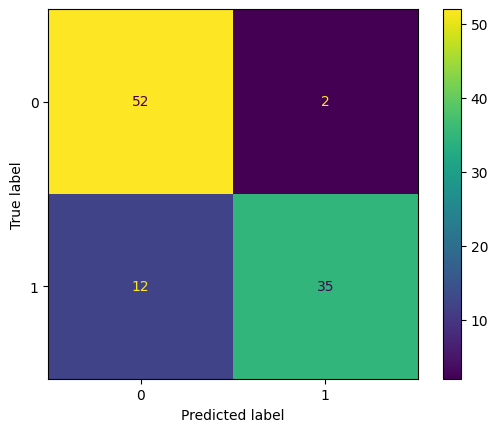

In [ ]:
# Call the function with appropriate paths
#process_videos_from_excel("/content/test_main_excel.xlsx", "/content/test_folder", "/content/output_folder_4")

model = get_model()
#prediction_df = predict_videos(model=model, main_folder_path="/content/drive/MyDrive/Arkitek/Arkitek-Fobi-Colab/Model_Datasets/video_classification/homophobia/training_videos/test_videomae_f30/scenes")

final_df = prediction_df.groupby("main_video_name").mean()

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, accuracy_score
y_true = final_df[2]
y_pred = final_df["scene_prediction"]
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
acc = accuracy_score(y_true, y_pred)
print("Accuracy:", acc)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

In [ ]:
for i, val in enumerate(prediction_df[prediction_df["scene_prediction"]!=prediction_df[2]]["urls"]):
  print(val)

/content/drive/MyDrive/Arkitek/Arkitek-Fobi-Colab/Model_Datasets/video_classification/homophobia/training_videos/test_videomae_f30/sceness/scenes/Best Movie Kisses Of All Time.mp4_10_1.mp4
/content/drive/MyDrive/Arkitek/Arkitek-Fobi-Colab/Model_Datasets/video_classification/homophobia/training_videos/test_videomae_f30/sceness/scenes/Best Movie Kisses Of All Time.mp4_10_2.mp4
/content/drive/MyDrive/Arkitek/Arkitek-Fobi-Colab/Model_Datasets/video_classification/homophobia/training_videos/test_videomae_f30/sceness/scenes/Best Movie Kisses Of All Time.mp4_12_1.mp4
/content/drive/MyDrive/Arkitek/Arkitek-Fobi-Colab/Model_Datasets/video_classification/homophobia/training_videos/test_videomae_f30/sceness/scenes/Best Movie Kisses Of All Time.mp4_12_2.mp4
/content/drive/MyDrive/Arkitek/Arkitek-Fobi-Colab/Model_Datasets/video_classification/homophobia/training_videos/test_videomae_f30/sceness/scenes/Best Movie Kisses Of All Time.mp4_12_3.mp4
/content/drive/MyDrive/Arkitek/Arkitek-Fobi-Colab/Model

In [ ]:
prediction_df

,urls,predictions,main_video_name,2,scene_prediction
0,/content/output_folder_4/gay_test_video108/tes...,0,gay_test_video108.mp4,0,0
1,/content/output_folder_4/gay_test_video108/tes...,0,gay_test_video108.mp4,0,0
2,/content/output_folder_4/gay_test_video108/tes...,0,gay_test_video108.mp4,0,0
3,/content/output_folder_4/gay_test_video108/tes...,0,gay_test_video108.mp4,0,0
4,/content/output_folder_4/gay_test_video21/test...,0,gay_test_video21.mp4,0,0
5,/content/output_folder_4/gay_test_video21/test...,0,gay_test_video21.mp4,0,0
6,/content/output_folder_4/gay_test_video5/test/...,0,gay_test_video5.mp4,1,1
7,/content/output_folder_4/gay_test_video5/test/...,0,gay_test_video5.mp4,1,1
8,/content/output_folder_4/gay_test_video5/test/...,0,gay_test_video5.mp4,1,1
9,/content/output_folder_4/gay_test_video5/test/...,0,gay_test_video5.mp4,1,1


### **TEST INDIVIDUAL VIDEO**

In [ ]:
sample_test_video = next(iter(test_dataset))
video_tensor = sample_test_video["video"]
display_gif(video_tensor)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


tensor([[[[ 1.3584,  1.3584,  1.3584,  ...,  0.2086,  0.1494,  0.2284],
          [ 1.3584,  1.3584,  1.3584,  ...,  0.4043,  0.4234,  0.3642],
          [ 1.3584,  1.3584,  1.3584,  ...,  0.4557,  0.5322,  0.4313],
          ...,
          [-0.3533, -0.6037, -0.8876,  ...,  0.2532,  0.1554,  0.0390],
          [-0.3969, -0.6442, -0.8876,  ...,  0.1555,  0.1371,  0.0147],
          [-0.4394, -0.6885, -0.8876,  ...,  0.1676,  0.1519,  0.0381]],

         [[ 1.3584,  1.3584,  1.3584,  ...,  0.3554,  0.3153,  0.3622],
          [ 1.3584,  1.3584,  1.3584,  ...,  0.4851,  0.4545,  0.4322],
          [ 1.3584,  1.3584,  1.3584,  ...,  0.4043,  0.4177,  0.4039],
          ...,
          [-0.0923, -0.4914, -0.7369,  ...,  0.1413,  0.1572,  0.0396],
          [-0.1206, -0.5120, -0.7772,  ...,  0.1756,  0.1685,  0.1179],
          [-0.1431, -0.5248, -0.8175,  ...,  0.2869,  0.3092,  0.2452]],

         [[ 1.3584,  1.3584,  1.3584,  ...,  0.4851,  0.4356,  0.4225],
          [ 1.3584,  1.3584,  

In [ ]:
logits = run_inference(model, sample_test_video["video"])
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

Predicted class: no_kiss
